In [12]:
import os
import numba
from pathlib import Path
from tqdm.auto import tqdm
from scipy.stats import mannwhitneyu

from aging.dlight.encoding_model import exp_smoother, run_simulation
from aging.dlight.windowing import window_trials_pro
from aging.plotting import legend, format_plots, figure, save_factory, PlotConfig
from aging.behavior.syllables import relabel_by_usage

from copy import deepcopy
from joblib import Parallel, delayed
from scipy.stats import zscore
from sklearn import model_selection
from scipy.stats import pearsonr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
numba.set_num_threads(int(os.environ.get("SLURM_JOB_CPUS_PER_NODE", 1)))

In [4]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "dlight", tight_layout=False)

In [5]:
import sys
from contextlib import redirect_stderr

terminal = sys.__stderr__

In [6]:
def get_peak_height(df, syllable_col="relabeled_syllables"):
    peaks = {}
    mask = df["onsets"]
    for syll in df[syllable_col].unique():
        syll_mask = df[syllable_col] == syll
        time, mtx = window_trials_as_mtx(
            df,
            np.where(mask & syll_mask)[0],
            "dlight_reref_zscore",
            truncation_window=(0, 0.3),
        )
        maxes = np.nanmax(mtx, axis=1)
        peaks[syll] = np.nanmean(maxes)
    ser = pd.Series(peaks, name="Peak DA")
    ser.index.name = "syllables"
    return ser

In [9]:
version = 12
file = Path(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/dlight_photometry_df_filter_stats_da_paper.parquet"
)

In [10]:
df = pd.read_parquet(file)
df['syllables'] = df['syllables'].ffill().astype(int)
df['onsets'] = (df['syllables'].diff() != 0).fillna(True).astype(bool)
df = df.query('syllables != -5').copy()
df = relabel_by_usage(df, return_map=False)
df['age'] = df['subject_name'].transform(lambda x: int(x.split('-')[0][:-1]))
df = df.query('snr > 5 & session_motion_corr < 0.25 & session_motion_corr > 0')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5294277 entries, 5 to 8249400
Data columns (total 24 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   pmt00_ref00 (dLight)        float64       
 1   pmt00_ref01 (UV)            float64       
 2   timestamp                   float64       
 3   raw_timestamp               float64       
 4   fs                          float64       
 5   ir_indices                  float64       
 6   subject_name                object        
 7   session_name                object        
 8   start_time                  datetime64[us]
 9   syllables                   int64         
 10  velocity                    float64       
 11  uuid                        object        
 12  dlight_dff                  float64       
 13  uv_dff                      float64       
 14  dlight_reref                float64       
 15  uv_reference_fit            float64       
 16  dlight_reref_zscore    

In [61]:
rle_df = []
gb_keys = ['age', 'uuid', 'subject_name']
for vals, _df in df.groupby(gb_keys, sort=False):
    agg_df, _ = window_trials_pro(
        _df,
        np.where(df["onsets"])[0],
        "dlight_reref_zscore",
        "relabeled_syllables",
        agg_window=(0, 0.3),
        avg_window=(0, 0.3),
    )
    for k, v in zip(gb_keys, vals):
        agg_df[k] = v
    agg_df['timestamp'] = _df['timestamp'].to_numpy()[agg_df['trial_index'].to_numpy()]
    
    rle_df.append(agg_df)
rle_df = pd.concat(rle_df, ignore_index=True)
rle_df = rle_df.astype(dict(labels='int32'))

In [6]:
# file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
file_suffix = "online"
load_file = os.path.join(raw_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [7]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"

dirname, filename = os.path.split(features_save_file)
file, ext = os.path.splitext(filename)
file = os.path.join(proc_dirs["dlight"], file)

if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

In [8]:
raw_feature_df = pd.read_parquet(features_save_file)

# helper functions

In [9]:
from numba import jit, prange


@jit(nopython=True, parallel=True)
def shuffle_rows(x):
    idx = np.arange(x.shape[1])
    y = np.empty((x.shape[0], x.shape[1]))
    for i in prange(x.shape[0]):
        tmp = np.random.randint(-x.shape[1], +x.shape[1])
        rolled_idx = np.roll(idx, int(tmp))
        y[i] = x[i][rolled_idx]
    return y

# Load in pre-processed data

## No-stim data

In [62]:
use_data = rle_df.copy()
syllable_key = "labels"
feature_key = "max"

In [63]:
cutoff = 2000

group_obj = use_data.groupby(["subject_name", "uuid"])
use_data = group_obj.filter(lambda x: (len(x.dropna(subset=[feature_key])) > cutoff))
group_obj = use_data.groupby(["subject_name", "uuid"])

In [64]:
# gather data, split off training data for optimizing hyperparameters
seqs = np.array([df[syllable_key].values[:cutoff] for k, df in group_obj])
uuids = np.array([df["uuid"].values[0] for k, df in group_obj])
features = np.array([df[feature_key].values[:cutoff] for k, df in group_obj])
timestamps = np.array([df["timestamp"].values[:cutoff] for k, df in group_obj])
keys = [k for k, _ in group_obj]

# zscore
features -= np.nanmean(features, axis=1, keepdims=True)
features /= np.nanstd(features, axis=1, keepdims=True)

In [66]:
conv_feature = (
    pd.get_dummies(
        pd.Series(seqs[0]).astype("category").cat.set_categories(np.arange(60))
    )
    * features[0][:, None]
)

## Plot an example

In [67]:
use_uuid = uuids[0]
use_idx = np.flatnonzero(uuids == use_uuid)[0]

In [68]:
conv_feature = (
    pd.get_dummies(
        pd.Series(seqs[use_idx]).astype("category").cat.set_categories(np.arange(60))
    )
    * features[use_idx][:, None]
)
conv_feature = conv_feature.values
results = exp_smoother(
    seqs[use_idx],
    conv_feature,
    nsyllables=10,
    entropy_tau=10.0,
    entropy_scaling=0.05,
    usage_tau=100.0,
    baseline_temperature=30.0,
    usage_scaling=250.0,
    log_variables=True,
)

In [69]:
format_plots()

(0.0, 250.0)

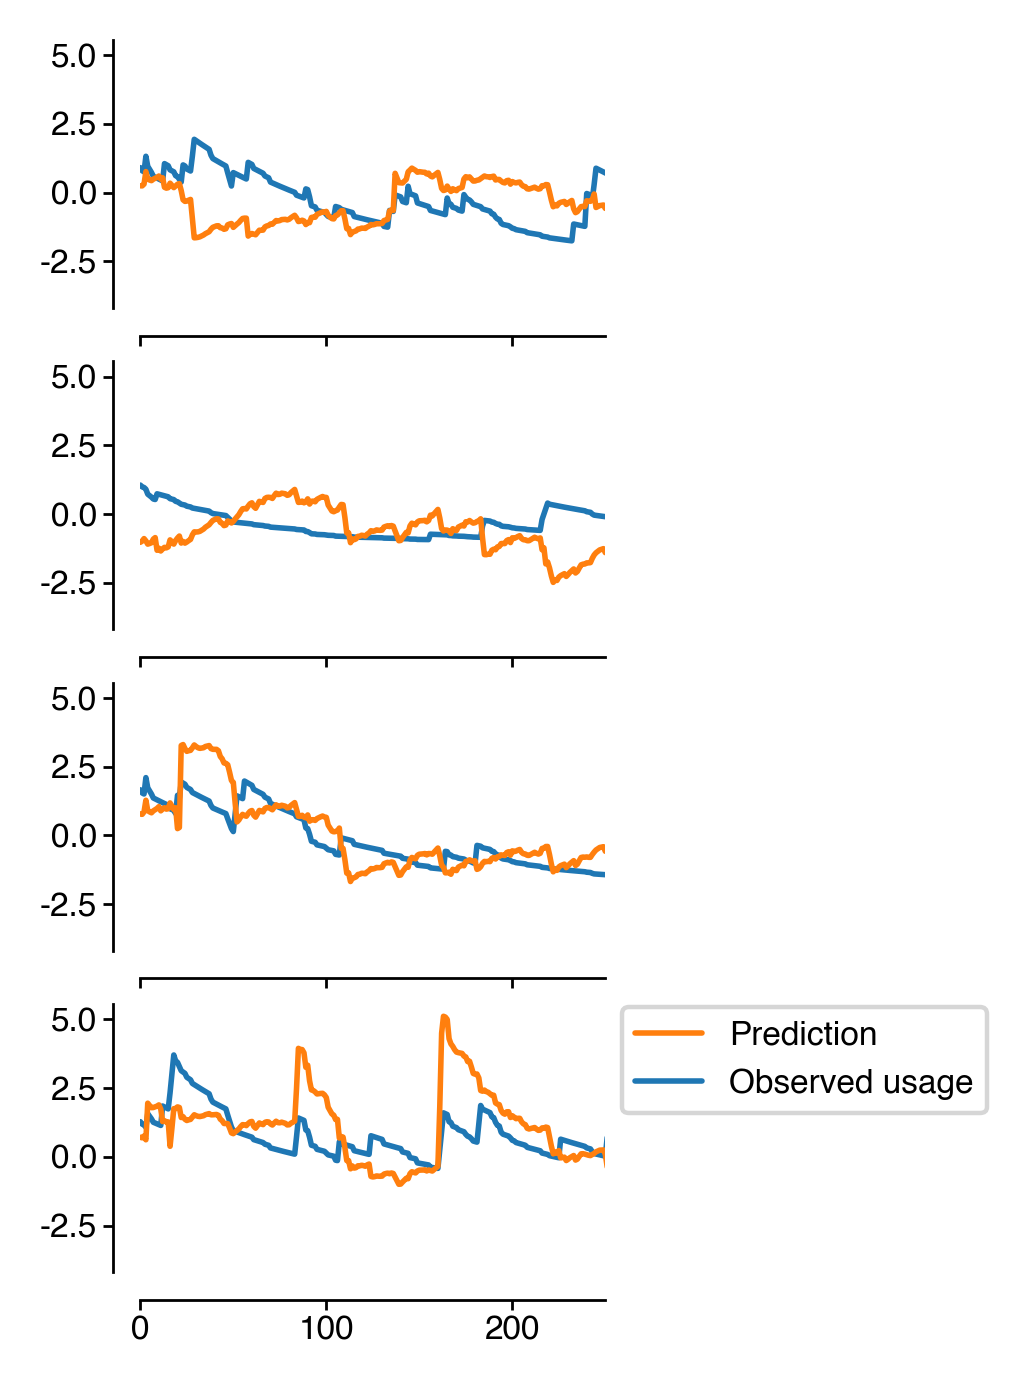

In [80]:
plt_examples = [5, 4, 3, 2]
burn_in = 100
fig, ax = plt.subplots(
    len(plt_examples), 1, figsize=(1.5, 1 * len(plt_examples)), sharex=True, sharey=True
)

for _example, _ax in zip(plt_examples, ax):
    (h2,) = _ax.plot(
        zscore(np.array(results["usage_tracker_history"])[burn_in:, _example]),
        label="Observed usage",
    )
    (h1,) = _ax.plot(
        zscore(np.array(results["probas_history"])[burn_in:, _example]),
        label="Prediction",
    )

sns.despine(offset=5)
plt.legend([h1, h2], ["Prediction", "Observed usage"], bbox_to_anchor=(1, 1.05))
plt.xlim(0, 250)
# clean_ticks(ax[-1], "x", precision=-1, dtype=int, zero_symmetry=False)
# clean_ticks(ax[-1], "y", precision=0, dtype=int)
# savefig(
#     fig,
#     os.path.join(figure_cfg["store_dir"], "decoding_model_examples"),
#     bbox_inches="tight",
# )

In [71]:
# plot exponential kernels, just send a SHOCK TO THE SYSTEM
taus = {}
taus["usage"] = 100.0
taus["entropy"] = 10.0

In [72]:
def simple_smoother(data, tau=100.0):
    alpha = 1.0 / tau
    ave = 0
    vals = []
    for _datum in data:
        ave = (1 - alpha) * ave + alpha * _datum
        vals.append(ave)
    return np.array(vals)

In [73]:
use_input = np.zeros((600,))
use_input[0] = 10.0

In [74]:
kernels = {}
for k, v in taus.items():
    kernels[k] = simple_smoother(use_input, v)

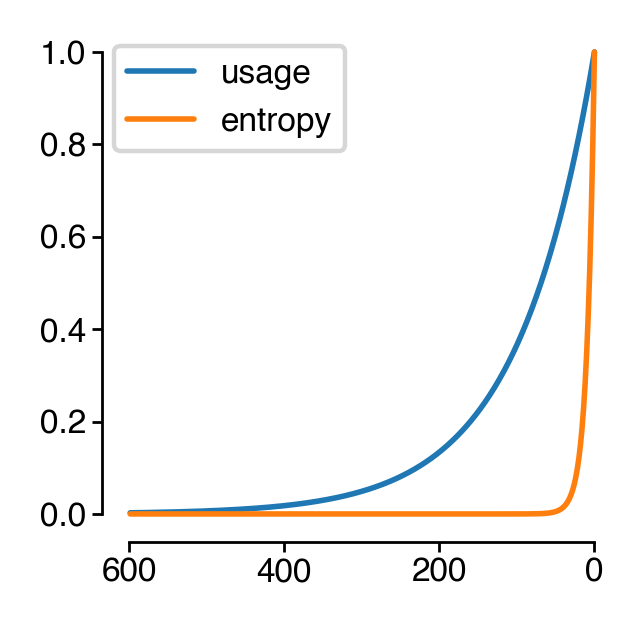

In [75]:
fig, ax = plt.subplots(1, figsize=(1.5, 1.5))
for k, v in kernels.items():
    plt.plot(v / v.max(), label=k, clip_on=False)
plt.xlim(600, 0)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(0.5, 1.05))
sns.despine(offset=5)
# clean_ticks(ax, "x", precision=-2, zero_symmetry=False, dtype=int)
# clean_ticks(ax, "y", precision=0, zero_symmetry=False, dtype=int)
# savefig(
#     fig,
#     os.path.join(figure_cfg["store_dir"], "decoding_model_kernels"),
#     bbox_inches="tight",
# )

## Repeated k-folds to z-score results

In [84]:
n_folds = 5
n_repeats = 2

In [86]:
parameter_scan_dct = [
    {
        "entropy_tau": [10.0],
        "usage_tau": [100.0],
        "entropy_scaling": [0.05],
        "baseline_temperature": [30.0],
        # "usage_scaling": np.round(np.arange(100.0, 500.1, 50.0), 3),
        "usage_scaling": np.round(np.arange(100.0, 500.1, 100.0), 3),
        "nsyllables": [10],
    }
]

In [87]:
param_iter = model_selection.ParameterGrid(parameter_scan_dct)

In [88]:
lag_func = lambda x: np.roll(x, 0, axis=1)

In [89]:
splits = model_selection.RepeatedKFold(
    n_splits=n_folds, n_repeats=n_repeats, random_state=0
)
use_splits = list(splits.split(seqs))
burn_in = 50
probas_cutoff = 300
eps = 1e-10

dcts = []

# get optimal parameters for every split
for i, (train_index, test_index) in tqdm(enumerate(use_splits), total=len(use_splits)):
    seqs_train, features_train = seqs[train_index], lag_func(features[train_index])

    for _param in param_iter:
        _dct = deepcopy(_param)
        _dct['fold'] = i
        _results = run_simulation(seqs_train, features_train, log_variables=True, **_param)
        rs = []
        ls = []
        norm_lls = []
        ave_rs = []
        concat_rs = []
        oracle_lls = []
    
        for _result in _results:
            _nsyllables = _result["probas_history"].shape[1]
            _rs = []
    
            if len(_result["probas_history"]) < probas_cutoff:
                continue
    
            uni_model = np.log((1.0 / _nsyllables) + eps)
            concat_rs.append(
                pearsonr(
                    _result["probas_history"].ravel(),
                    _result["usage_tracker_history"][:, :_nsyllables].ravel(),
                )[0]
            )
            oracle_lls.append(_result["ll_oracle"])
            ls.append(_result["ll"])
            norm_lls.append(
                (_result["ll"] - uni_model) / (_result["ll_oracle"] - uni_model)
            )
        _dct["r_concat"] = np.mean(concat_rs)
        _dct["ll"] = np.mean(ls)
        _dct["ll_norm"] = np.mean(norm_lls)
        _dct["ll_oracle"] = np.mean(oracle_lls)
        dcts.append(_dct)

  0%|          | 0/10 [00:00<?, ?it/s]

In [90]:
results_df = pd.DataFrame(dcts).set_index(list(param_iter[0].keys()))

In [91]:
optimal_parameters = results_df.groupby("fold")["ll"].idxmax()

In [92]:
optimal_parameters

fold
0    (100.0, 300.0, 10, 10.0, 0.05, 30.0)
1    (100.0, 300.0, 10, 10.0, 0.05, 30.0)
2    (100.0, 300.0, 10, 10.0, 0.05, 30.0)
3    (100.0, 300.0, 10, 10.0, 0.05, 30.0)
4    (100.0, 300.0, 10, 10.0, 0.05, 30.0)
5    (100.0, 300.0, 10, 10.0, 0.05, 30.0)
6    (100.0, 300.0, 10, 10.0, 0.05, 30.0)
7    (100.0, 300.0, 10, 10.0, 0.05, 30.0)
8    (100.0, 300.0, 10, 10.0, 0.05, 30.0)
9    (100.0, 300.0, 10, 10.0, 0.05, 30.0)
Name: ll, dtype: object

<Axes: xlabel='usage_scaling'>

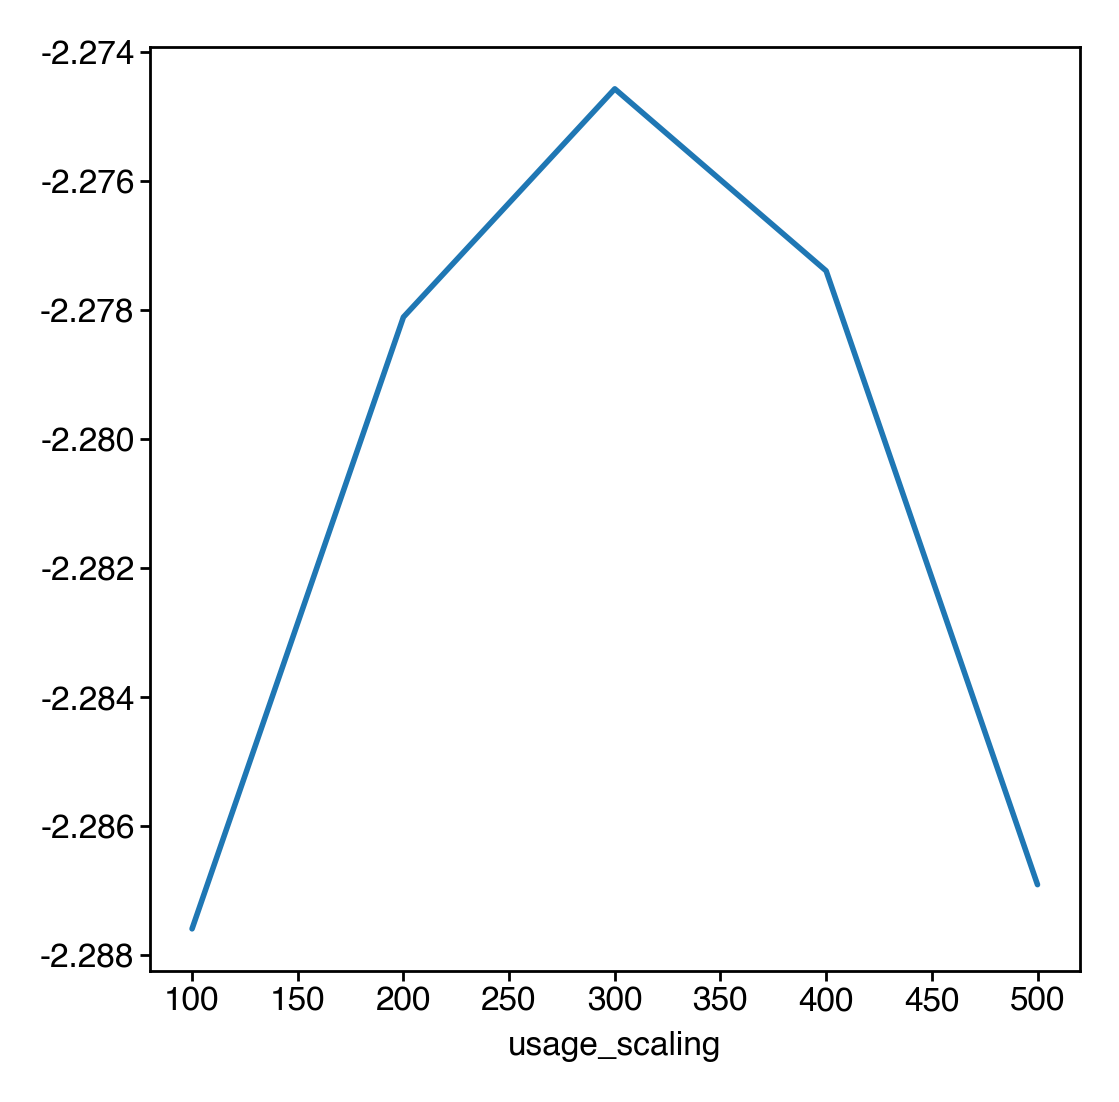

In [95]:
results_df.groupby('usage_scaling').mean()['ll'].plot()

<Axes: xlabel='usage_scaling'>

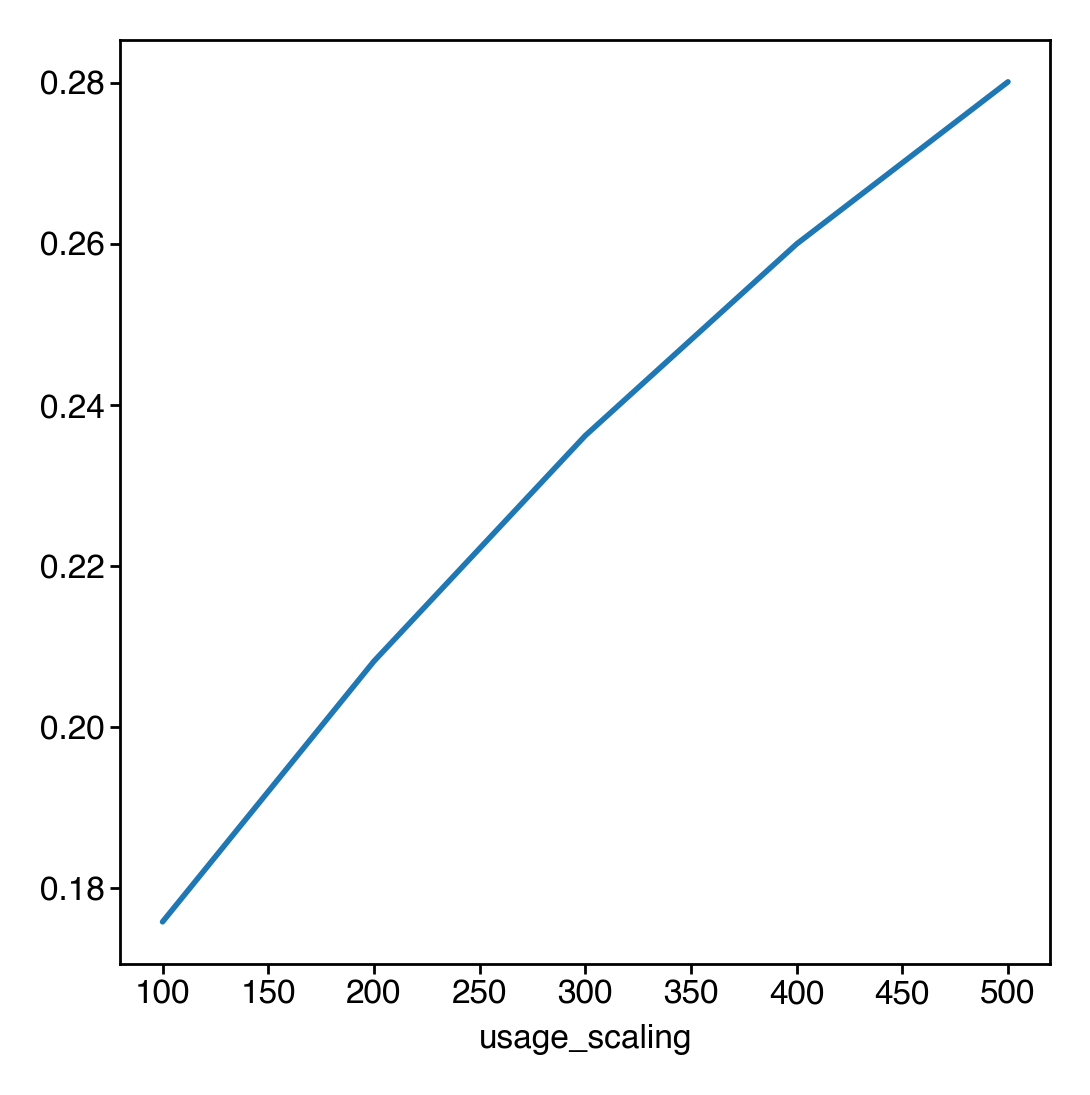

In [97]:
results_df.groupby('usage_scaling').mean()['r_concat'].plot()

In [37]:
# use optimal parameters for every split
# compare against the many many controls...
store_dcts = []
delays = []
for i, (train_index, test_index) in enumerate(use_splits):
    seqs_test, features_test = seqs[test_index], lag_func(features[test_index])

    use_params_tup = optimal_parameters[i]
    param_names = results_df.index.names
    _param = {k: v for k, v in zip(param_names, use_params_tup)}

    random_dist = np.zeros_like(features_test)
    for j in range(features_test.shape[0]):
        random_dist[j] = np.random.randn(features_test.shape[1])
        random_dist[j] *= np.nanstd(features_test[j])
        random_dist[j] += np.nanmean(features_test[j])

    random_shift = np.roll(features_test, np.random.randint(1, 1000), axis=1)

    check_data = {
        "dlight": features_test,
        "random_dist": random_dist,
        "random_shift": random_shift,
    }

    for k, v in check_data.items():
        delays.append(
            use_delayed(run_simulation)(seqs_test, v, log_variables=True, **_param)
        )
        store_dct = deepcopy(_param)
        store_dct["fold"] = i
        store_dct["type"] = k
        store_dcts.append(store_dct)

In [38]:
if dask_address is not None:
    futures = client.compute(delays)
    results = client.gather(futures)
else:
    results = Parallel(n_jobs=-2, verbose=10, backend="loky")(delays)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 127 concurrent workers.
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-2)]: Done  59 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-2)]: Done 111 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-2)]: Done 138 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-2)]: Done 167 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-2)]: Done 196 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-2)]: Done 227 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-2)]: Done 258 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-2)]: Done 291 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-2)]: Done 324 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-2)]: Done 394 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-2)]: Done 431 tasks      | elapsed: 

In [39]:
dcts = []
burn_in = 25
probas_cutoff = 300
eps = 1e-10

for _results, _params in tqdm(zip(results, store_dcts), total=len(results)):
    _dct = deepcopy(_params)
    rs = []
    ls = []
    norm_lls = []
    ave_rs = []
    concat_rs = []
    oracle_concat_rs = []
    oracle_lls = []

    use_idx = use_splits[_params["fold"]][1]
    use_seqs = seqs[use_idx]

    all_usage_history = []
    for _result in _results:
        if len(_result["probas_history"]) < probas_cutoff:
            continue
        all_usage_history.append(_result["usage_tracker_history"][:probas_cutoff])

    usage_mean = np.mean(all_usage_history, axis=0)

    for _result in _results:
        _nsyllables = _result["probas_history"].shape[1]
        _rs = []

        if len(_result["probas_history"]) < probas_cutoff:
            continue

        uni_model = np.log((1.0 / _nsyllables) + eps)

        ave_rs.append(
            pearsonr(
                _result["probas_history"].mean(axis=0),
                _result["usage_tracker_history"].mean(axis=0)[:_nsyllables],
            )[0]
        )
        concat_rs.append(
            pearsonr(
                pd.DataFrame(_result["probas_history"])[burn_in:probas_cutoff]
                .rolling(50, 1, True)
                .mean()
                .values.ravel(),
                pd.DataFrame(
                    _result["usage_tracker_history"][
                        burn_in:probas_cutoff, :_nsyllables
                    ]
                )
                .rolling(50, 1, True)
                .mean()
                .values.ravel(),
            )[0]
        )
        oracle_concat_rs.append(
            pearsonr(
                pd.DataFrame(usage_mean[burn_in:probas_cutoff, :_nsyllables])
                .rolling(50, 1, True)
                .mean()
                .values.ravel(),
                pd.DataFrame(
                    _result["usage_tracker_history"][
                        burn_in:probas_cutoff, :_nsyllables
                    ]
                )
                .rolling(50, 1, True)
                .mean()
                .values.ravel(),
            )[0]
        )
        oracle_lls.append(_result["ll_oracle"])
        ls.append(_result["ll"])
        # norm_lls.append(_result["ll"] - uni_model)
        norm_lls.append(
            (_result["ll"] - uni_model) / (_result["ll_oracle"] - uni_model)
        )
        # rs.append(np.mean(_rs))
    _dct["r_concat"] = np.mean(concat_rs)
    _dct["r_concat_oracle"] = np.mean(oracle_concat_rs)
    _dct["ll"] = np.mean(ls)
    _dct["ll_norm"] = np.mean(norm_lls)
    _dct["ll_oracle"] = np.mean(oracle_lls)
    # _dct["r"] = np.mean(rs)
    _dct["ave_r"] = np.mean(ave_rs)
    dcts.append(_dct)

  0%|          | 0/750 [00:00<?, ?it/s]

In [40]:
results_test_df = pd.DataFrame(dcts)

In [41]:
results_test_df["repeat"] = np.floor(results_test_df["fold"] / n_folds).astype("int")
results_test_df["ll_norm"] = results_test_df["ll"] - results_test_df["ll_oracle"]

In [42]:
mu_test_results = results_test_df.groupby(["type", "repeat"]).mean()
sig_test_results = results_test_df.groupby(["type", "repeat"]).std()

In [43]:
setup_plotting_env()
# sns.set_context("paper")

In [44]:
ncolors = results_test_df["type"].nunique()
pal = [sns.color_palette()[1]]
pal += [sns.color_palette()[0]] * (ncolors - 1)

In [45]:
setup_plotting_env()
# sns.set_context("paper")

In [46]:
results_test_df["r_concat_fraction"] = (
    results_test_df["r_concat"] / results_test_df["r_concat_oracle"]
)

In [47]:
oracle_ave = results_test_df["r_concat_oracle"].mean()

In [48]:
correlation_to_fraction = lambda x: x / oracle_ave
fraction_to_correlation = lambda x: x * oracle_ave

In [49]:
eps = 1e-5

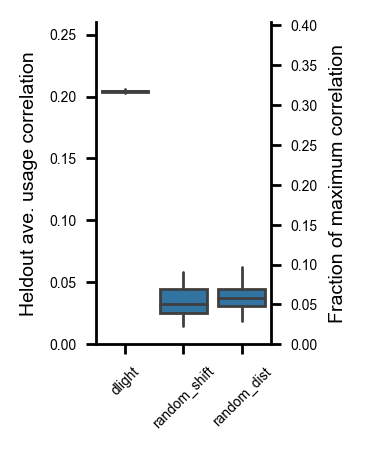

In [50]:
g = sns.catplot(
    data=results_test_df.groupby(["type", "repeat"]).mean().reset_index(),
    x="type",
    order=["dlight", "random_shift", "random_dist"],
    y="r_concat",
    showfliers=False,
    showcaps=False,
    palette=pal,
    kind="box",
)
g.fig.set_size_inches(1, 1.8)
g.set(ylabel="Heldout ave. usage correlation", ylim=(0, 0.26), xlabel="")


secax_y = g.ax.secondary_yaxis(
    "right", functions=(correlation_to_fraction, fraction_to_correlation)
)
secax_y.set_ylabel("Fraction of maximum correlation")
fraction_to_correlation(secax_y.get_ylim()[-1])
g.set_xticklabels(rotation=45)

savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "decoding_model_performance_v_controls"),
    bbox_inches="tight",
)

In [51]:
stats = {}
stats["baseline"] = {}

In [52]:
compare_base = "dlight"
compare_groups = ["random_shift", "random_dist"]
compare_df = results_test_df.groupby(["type", "repeat"]).mean()
use_test = mannwhitneyu
for _group in compare_groups:
    stat, p = use_test(
        compare_df.loc[compare_base]["r_concat"], compare_df.loc[_group]["r_concat"]
    )
    group = str((compare_base, _group))
    stats["baseline"][group] = {}
    stats["baseline"][group]["test_type"] = str(use_test.__name__)
    stats["baseline"][group]["p"] = p
    stats["baseline"][group]["test_stat"] = stat
    stats["baseline"][group]["n"] = n_repeats
    stats["baseline"][group]["n_definition"] = "model repeats"
for _group in compare_df.index.get_level_values("type").unique():
    stats["baseline"][_group] = {}
    for k, v in compare_df.loc[_group]["r_concat"].describe().items(): 
        stats["baseline"][_group][k] = v

## Stim

In [53]:
use_data = pd.read_parquet(
    os.path.join(raw_dirs["rl_modeling"], "rl_modeling_dlight_data_online.parquet")
).reset_index()
use_data = dlight_exclude(
    use_data, exclude_3s=False, exclude_stim=False, exclude_target=False, **dlight_cfg
)
use_data = use_data.loc[use_data["stim_duration"] == 0.25].copy()

In [54]:
features_df = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_snippets_online_features.parquet")
)
features_df = features_df.loc[
    (features_df["area"] == "dls") & (features_df["session_number"].isin([1, 2]))
].copy()
features_df = features_df.loc[
    (features_df["window_tup"] == "(0.0, 0.6)") & (features_df["is_feedback_any"] == 1)
].copy()

In [55]:
use_data["prev_syllable"] = use_data.groupby("uuid")["syllable"].shift(1)
use_data["next_syllable"] = use_data.groupby("uuid")["syllable"].shift(-1)

In [56]:
for _status_field in ["is_catch_any", "is_feedback_any"]:
    # previous misses
    prev_syllable_idx = use_data.loc[
        (_status_field == 1)
        & (use_data["syllable"] != use_data["target_syllable"])
        & (use_data["prev_syllable"] == use_data["target_syllable"])
    ].index

    # next misses
    next_syllable_idx = use_data.loc[
        (_status_field == 1)
        & (use_data["syllable"] != use_data["target_syllable"])
        & (use_data["next_syllable"] == use_data["target_syllable"])
    ].index

    use_data.loc[prev_syllable_idx, _status_field] = False
    use_data.loc[prev_syllable_idx - 1, _status_field] = True
    use_data.loc[next_syllable_idx, _status_field] = False
    use_data.loc[next_syllable_idx + 1, _status_field] = True

In [57]:
use_data = use_data.loc[use_data["session_number"].isin([1, 2])].copy()

In [58]:
min_catch = 5
cutoff = 2500

group_obj = use_data.groupby(["mouse_id", "uuid"])
use_data = group_obj.filter(
    lambda x: (len(x.dropna(subset=[feature_key])) > cutoff)
    & (x["is_catch_any"].iloc[:cutoff].sum() >= min_catch)
)
group_obj = use_data.groupby(["mouse_id", "uuid"])

# gather data, split off training data for optimizing hyperparameters
seqs = np.array([df[syllable_key].values[:cutoff] for k, df in group_obj])
features = np.array([df[feature_key].values[:cutoff] for k, df in group_obj])
timestamps = np.array([df["timestamp"].values[:cutoff] for k, df in group_obj])
targets = np.array([df["target_syllable"].iat[0] for k, df in group_obj]).astype("int")

fbacks = np.array([df["is_feedback_any"].values[:cutoff] for k, df in group_obj]) == 1
catches = np.array([df["is_catch_any"].values[:cutoff] for k, df in group_obj]) == 1

# nan out feedbacks prior to zscore

features[fbacks] = np.nan

features -= np.nanmean(features, axis=1, keepdims=True)
features /= np.nanstd(features, axis=1, keepdims=True)

feedback_status = np.zeros_like(features)
feedback_status[catches] = 2
feedback_status[fbacks] = 1

keys = [k for k, _ in group_obj]

In [59]:
optimal_parameters

fold
0      (100.0, 250.0, 10, 10.0, 0.05, 30.0)
1      (100.0, 250.0, 10, 10.0, 0.05, 30.0)
2      (100.0, 250.0, 10, 10.0, 0.05, 30.0)
3      (100.0, 250.0, 10, 10.0, 0.05, 30.0)
4      (100.0, 250.0, 10, 10.0, 0.05, 30.0)
                       ...                 
245    (100.0, 250.0, 10, 10.0, 0.05, 30.0)
246    (100.0, 250.0, 10, 10.0, 0.05, 30.0)
247    (100.0, 250.0, 10, 10.0, 0.05, 30.0)
248    (100.0, 250.0, 10, 10.0, 0.05, 30.0)
249    (100.0, 250.0, 10, 10.0, 0.05, 30.0)
Name: ll, Length: 250, dtype: object

In [60]:
use_parameters = optimal_parameters.apply(pd.Series).mean()

In [61]:
parameter_scan_dct = {
    k: [np.around(v, 3)] for k, v in zip(results_df.index.names, use_parameters)
}

In [62]:
parameter_scan_dct["stim_offset"] = np.around(np.arange(0.0, 10.1, 0.5), 3)

In [63]:
parameter_scan_dct

{'usage_tau': [100.0],
 'usage_scaling': [250.0],
 'nsyllables': [10.0],
 'entropy_tau': [10.0],
 'entropy_scaling': [0.05],
 'baseline_temperature': [30.0],
 'stim_offset': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])}

In [64]:
param_iter = model_selection.ParameterGrid(parameter_scan_dct)

In [65]:
splits = model_selection.RepeatedKFold(
    n_splits=n_folds, n_repeats=n_repeats, random_state=0
)
use_splits = list(splits.split(seqs))

In [66]:
delays = []
store_dcts = []

for i, (train_index, test_index) in enumerate(use_splits):
    for _param in param_iter:
        # spam out reference and dlight, subtract off
        delays.append(
            use_delayed(run_simulation_stim)(
                seqs[train_index],
                features[train_index],
                targets[train_index],
                feedback_status[train_index],
                control=False,
                log_variables=True,
                **_param
            )
        )
        store_dct = deepcopy(_param)
        store_dct["fold"] = i
        store_dct["signal"] = "dlight"
        store_dcts.append(store_dct)

In [67]:
print(len(delays))

5250


In [68]:
if dask_address is not None:
    futures = client.compute(delays)
    results = client.gather(futures)
else:
    results = Parallel(n_jobs=-2, verbose=10, backend="loky")(delays)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 127 concurrent workers.
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-2)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-2)]: Done  59 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-2)]: Done 111 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-2)]: Done 138 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-2)]: Done 167 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-2)]: Done 196 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-2)]: Done 227 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-2)]: Done 258 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-2)]: Done 291 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-2)]: Done 324 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-2)]: Done 394 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-2)]: Done 431 tasks      | elapsed: 

In [69]:
dcts = []
burn_in = 25
probas_cutoff = 300
eps = 1e-10

for _results, _params in tqdm(zip(results, store_dcts), total=len(results)):
    _dct = deepcopy(_params)
    rs = []
    ls = []
    norm_lls = []
    ave_rs = []
    concat_rs = []
    oracle_lls = []

    use_idx = use_splits[_params["fold"]][1]
    use_seqs = seqs[use_idx]

    for _result in _results:
        _nsyllables = _result["probas_history"].shape[1]
        _rs = []

        if len(_result["probas_history"]) < probas_cutoff:
            continue

        uni_model = np.log((1.0 / _nsyllables) + eps)

        ave_rs.append(
            pearsonr(
                _result["probas_history"].mean(axis=0),
                _result["usage_tracker_history"].mean(axis=0)[:_nsyllables],
            )[0]
        )
        concat_rs.append(
            pearsonr(
                pd.DataFrame(_result["probas_history"])[burn_in:]
                .rolling(50, 1, True)
                .mean()
                .values.ravel(),
                pd.DataFrame(_result["usage_tracker_history"][burn_in:, :_nsyllables])
                .rolling(50, 1, True)
                .mean()
                .values.ravel(),
            )[0]
        )
        oracle_lls.append(_result["ll_oracle"])
        ls.append(_result["ll"])
        norm_lls.append(
            (_result["ll"] - uni_model) / (_result["ll_oracle"] - uni_model)
        )
    _dct["r_concat"] = np.mean(concat_rs)
    _dct["ll"] = np.mean(ls)
    _dct["ll_norm"] = np.mean(norm_lls)
    _dct["ll_oracle"] = np.mean(oracle_lls)
    _dct["ave_r"] = np.mean(ave_rs)
    dcts.append(_dct)

  0%|          | 0/5250 [00:00<?, ?it/s]

In [70]:
results_stim_df = pd.DataFrame(dcts).set_index(list(param_iter[0].keys()))
results_stim_df["repeat"] = np.floor(results_stim_df["fold"] / n_folds).astype("int")

In [71]:
mu = results_stim_df.groupby(["repeat", "stim_offset"]).mean().reset_index()

/tmp/ipykernel_1389913/401514099.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mu = results_stim_df.groupby(["repeat", "stim_offset"]).mean().reset_index()


In [72]:
setup_plotting_env()

In [73]:
sns.color_palette()[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

/tmp/ipykernel_1389913/125314694.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
/tmp/ipykernel_1389913/125314694.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


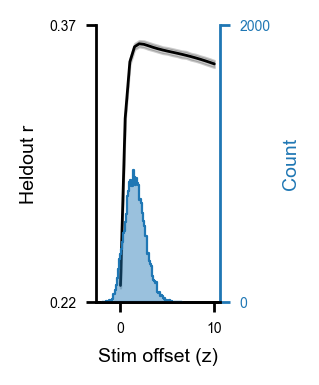

In [74]:
curve_color = "k"
hist_color = sns.color_palette()[0]

fig, ax = plt.subplots(1, figsize=(.8, 1.8), sharex=True)
sns.lineplot(
    data=results_stim_df.reset_index(),
    x="stim_offset",
    y="r_concat",
    color=curve_color,
    ci=95,
    ax=ax,
)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_color(curve_color)
ax.tick_params(axis="y", colors=curve_color, labelcolor=curve_color)
ax.set_ylabel("Heldout r", color=curve_color)
ax.set_xlabel("Stim offset (z)")

ax2 = ax.twinx()
ax2.spines["left"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_color(hist_color)
ax2.tick_params(axis="y", colors=hist_color, labelcolor=hist_color)

sns.histplot(
    features_df["signal_reref_dff_z_max"],
    ax=ax2,
    alpha=0.45,
    color=hist_color,
    element="step",
)

ax2.set_ylim(0, 1500)
ax2.set_ylabel("Count", color=hist_color)
clean_ticks(ax, "y", precision=2)
clean_ticks(ax2, "y", precision=-3, dtype=int)
fig.tight_layout()
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"], "decoding_model_stim_offset_optimization_overlay"
    ),
    bbox_inches="tight",
)

In [75]:
optimal_parameters = results_stim_df.groupby("fold")["ll"].idxmax()

In [76]:
# use optimal parameters for every split
# compare against the many many controls...
store_dcts = []
delays = []
for i, (train_index, test_index) in enumerate(use_splits):
    seqs_test, features_test = seqs[test_index], features[test_index]
    targets_test, feedback_status_test = (
        targets[test_index],
        feedback_status[test_index],
    )

    use_params_tup = optimal_parameters[i]
    try:
        iter(use_params_tup)
    except TypeError:
        use_params_tup = (use_params_tup,)
    param_names = results_stim_df.index.names
    _param = {k: v for k, v in zip(param_names, use_params_tup)}

    random_dist = np.zeros_like(features_test)
    for j in range(features_test.shape[0]):
        random_dist[j] = np.random.randn(features_test.shape[1])
        random_dist[j] *= np.nanstd(features_test[j])
        random_dist[j] += np.nanmean(features_test[j])

    shift = np.random.randint(1, 1000)
    random_shift = np.roll(features_test, shift, axis=1)
    random_shift_status = np.roll(feedback_status_test, shift, axis=1)

    check_data = {
        "dlight": (features_test, feedback_status_test),
        "random_dist": (random_dist, feedback_status_test),
        "random_shift": (random_shift, feedback_status_test),
    }

    for k, (v, v_status) in check_data.items():
        if k == "dlight":
            control = False
        else:
            control = True
        
        delays.append(
            use_delayed(run_simulation_stim)(
                seqs_test,
                v,
                targets_test,
                v_status,
                control=control,
                log_variables=True,
                **_param
            )
        )
        store_dct = {}
        store_dct["fold"] = i
        store_dct["type"] = k
        store_dcts.append(store_dct)

    delays.append(
        use_delayed(run_simulation_stim)(
            seqs_test,
            features_test,
            targets_test,
            feedback_status_test,
            control=False,
            log_variables=True,
            **{**_param, **{"stim_offset": 0}}
        )
    )
    store_dct = {}
    store_dct["fold"] = i
    store_dct["type"] = "no_offset"
    store_dcts.append(store_dct)

In [77]:
print(len(delays))

1000


In [78]:
if dask_address is not None:
    futures = client.compute(delays)
    results = client.gather(futures)
else:
    results = Parallel(n_jobs=-2, verbose=10, backend="loky")(delays)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 127 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done  85 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 112 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 139 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-2)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 197 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 228 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 259 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 292 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 325 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 360 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 395 tasks      | elapsed: 

In [79]:
dcts = []
burn_in = 25
probas_cutoff = 300
eps = 1e-10

for _results, _params in tqdm(zip(results, store_dcts), total=len(results)):
    _dct = deepcopy(_params)
    rs = []
    ls = []
    norm_lls = []
    ave_rs = []
    concat_rs = []
    oracle_concat_rs = []
    oracle_lls = []

    use_idx = use_splits[_params["fold"]][1]
    use_seqs = seqs[use_idx]

    all_usage_history = []
    for _result in _results:
        if len(_result["probas_history"]) < probas_cutoff:
            continue
        all_usage_history.append(_result["usage_tracker_history"][:probas_cutoff])

    usage_mean = np.mean(all_usage_history, axis=0)

    for _result in _results:
        _nsyllables = _result["probas_history"].shape[1]
        _rs = []

        if len(_result["probas_history"]) < probas_cutoff:
            continue

        uni_model = np.log((1.0 / _nsyllables) + eps)

        ave_rs.append(
            pearsonr(
                _result["probas_history"].mean(axis=0),
                _result["usage_tracker_history"].mean(axis=0)[:_nsyllables],
            )[0]
        )
        concat_rs.append(
            pearsonr(
                pd.DataFrame(_result["probas_history"])[burn_in:probas_cutoff]
                .rolling(50, 1, True)
                .mean()
                .values.ravel(),
                pd.DataFrame(
                    _result["usage_tracker_history"][
                        burn_in:probas_cutoff, :_nsyllables
                    ]
                )
                .rolling(50, 1, True)
                .mean()
                .values.ravel(),
            )[0]
        )
        oracle_concat_rs.append(
            pearsonr(
                pd.DataFrame(usage_mean[burn_in:probas_cutoff, :_nsyllables])
                .rolling(50, 1, True)
                .mean()
                .values.ravel(),
                pd.DataFrame(
                    _result["usage_tracker_history"][
                        burn_in:probas_cutoff, :_nsyllables
                    ]
                )
                .rolling(50, 1, True)
                .mean()
                .values.ravel(),
            )[0]
        )
        oracle_lls.append(_result["ll_oracle"])
        ls.append(_result["ll"])
        norm_lls.append(
            (_result["ll"] - uni_model) / (_result["ll_oracle"] - uni_model)
        )
    _dct["r_concat"] = np.mean(concat_rs)
    _dct["r_concat_oracle"] = np.mean(oracle_concat_rs)
    _dct["ll"] = np.mean(ls)
    _dct["ll_norm"] = np.mean(norm_lls)
    _dct["ll_oracle"] = np.mean(oracle_lls)
    _dct["ave_r"] = np.mean(ave_rs)
    dcts.append(_dct)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [80]:
results_stim_test_df = pd.DataFrame(dcts)
results_stim_test_df["repeat"] = np.floor(
    results_stim_test_df["fold"] / n_folds
).astype("int")

In [81]:
ncolors = results_stim_test_df["type"].nunique()
pal = [sns.color_palette()[1]]
pal += [sns.color_palette()[0]] * (ncolors - 1)

In [82]:
setup_plotting_env()
# sns.set_context("paper")

In [83]:
results_stim_test_df["r_concat_fraction"] = (
    results_stim_test_df["r_concat"] / results_stim_test_df["r_concat_oracle"]
)

In [84]:
oracle_ave = results_stim_test_df["r_concat_oracle"].mean()

In [85]:
correlation_to_fraction = lambda x: x / oracle_ave
fraction_to_correlation = lambda x: x * oracle_ave

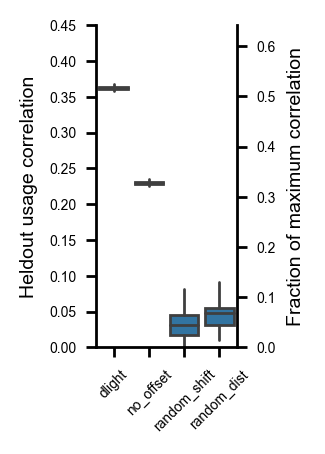

In [86]:
g = sns.catplot(
    data=results_stim_test_df.groupby(["type", "repeat"]).mean().reset_index(),
    x="type",
    order=["dlight", "no_offset", "random_shift", "random_dist"],
    y="r_concat",
    showfliers=False,
    showcaps=False,
    palette=pal,
    color=sns.color_palette()[0],
    kind="box",
)


g.set(ylabel="Heldout usage correlation", xlabel="", ylim=(0, 0.45))
secax_y = g.ax.secondary_yaxis(
    "right", functions=(correlation_to_fraction, fraction_to_correlation)
)
secax_y.set_ylabel("Fraction of maximum correlation")

g.set_xticklabels(rotation=45)
g.fig.set_size_inches(0.8, 1.8)
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "decoding_model_stim_performance_v_controls"),
    bbox_inches="tight",
)

In [87]:
stats["stim"] = {}

In [88]:
compare_base = "dlight"
compare_groups = ["no_offset", "random_shift", "random_dist"]
compare_df = results_stim_test_df.groupby(["type", "repeat"]).mean()
use_test = mannwhitneyu
for _group in compare_groups:
    stat, p = use_test(
        compare_df.loc[compare_base]["r_concat"], compare_df.loc[_group]["r_concat"]
    )
    group = str((compare_base, _group))
    stats["stim"][group] = {}
    stats["stim"][group]["test_type"] = str(use_test.__name__)
    stats["stim"][group]["p"] = p
    stats["stim"][group]["test_stat"] = stat
    stats["stim"][group]["n"] = n_repeats
    stats["stim"][group]["n_definition"] = "model repeats"
for _group in compare_df.index.get_level_values("type").unique():
    stats["stim"][_group] = {}
    for k, v in compare_df.loc[_group]["r_concat"].describe().items(): 
        stats["stim"][_group][k] = v

In [89]:
with open(
    os.path.join(proc_dirs["dlight"], "stats_decoding_model_exponential.toml"), "w"
) as f:
    toml.dump(stats, f)